In [1]:
# Import required libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import pylab
from scipy import stats

sns.set()

In [4]:
# Load dataset
orders = pd.read_csv('orders_data.csv').drop(['Unnamed: 0'],axis=1)
orders.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Description,CancelledOrder,InternationalOrders,TotalPrice
0,489434,85048,12,2009-12-01 07:45:00,6.95,C13085,United Kingdom,15CM CHRISTMAS GLASS BALL 20 LIGHTS,0,0,83.4
1,489434,79323P,12,2009-12-01 07:45:00,6.75,C13085,United Kingdom,PINK CHERRY LIGHTS,0,0,81.0
2,489434,79323W,12,2009-12-01 07:45:00,6.75,C13085,United Kingdom,WHITE CHERRY LIGHTS,0,0,81.0
3,489434,22041,48,2009-12-01 07:45:00,2.10,C13085,United Kingdom,"RECORD FRAME 7"" SINGLE SIZE",0,0,100.8
4,489434,21232,24,2009-12-01 07:45:00,1.25,C13085,United Kingdom,STRAWBERRY CERAMIC TRINKET BOX,0,0,30.0


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820164 entries, 0 to 820163
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Invoice              820164 non-null  object 
 1   StockCode            820164 non-null  object 
 2   Quantity             820164 non-null  int64  
 3   InvoiceDate          820164 non-null  object 
 4   Price                820164 non-null  float64
 5   Customer ID          820164 non-null  object 
 6   Country              820164 non-null  object 
 7   Description          820164 non-null  object 
 8   CancelledOrder       820164 non-null  int64  
 9   InternationalOrders  820164 non-null  int64  
 10  TotalPrice           820164 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 68.8+ MB


In [6]:
# Convert InvoiceDate to datetime object
orders.InvoiceDate = pd.to_datetime(orders.InvoiceDate)

# Truncate the minutes part of datetime object
orders['InvoiceDate'] = orders.InvoiceDate.dt.date

In [7]:
# Confirm all cancelled orders have negative TotalPrice and Quantity

print(orders[(orders.Invoice.str.startswith('C')) & (orders.TotalPrice>0)])
print(orders[(orders.Invoice.str.startswith('C')) & (orders.Quantity>0)])

Empty DataFrame
Columns: [Invoice, StockCode, Quantity, InvoiceDate, Price, Customer ID, Country, Description, CancelledOrder, InternationalOrders, TotalPrice]
Index: []
Empty DataFrame
Columns: [Invoice, StockCode, Quantity, InvoiceDate, Price, Customer ID, Country, Description, CancelledOrder, InternationalOrders, TotalPrice]
Index: []


We will drop following columns:
1. InvoiceNo and CustomerID: As we have to predict itemwise sales, we don't need these columns 
1. Country, InternationalOrders: We are not making distinction between international or domestic sales in the predictions, so we don't need this column
1. Description: We have the StockCode, so this is repetitive
1. CancelledOrder: Cancelled orders have negative quantity and price. So while aggregating the dataset, cancellations will be taken into account. We don't need this column.
1. UnitPrice: In our dataset, same item has different prices. So we will keep TotalPrice and drop UnitPrice. While aggregating we will calculate the UnitPrice from TotalPrice and Quantity for each item and month again.

In [8]:
orders.drop(['Invoice', 'Customer ID','Country','InternationalOrders','Description','CancelledOrder','Price'],
            axis=1,inplace=True)

### Feature Engineering

In [9]:
orders.head()

,StockCode,Quantity,InvoiceDate,TotalPrice
0,85048,12,2009-12-01,83.4
1,79323P,12,2009-12-01,81.0
2,79323W,12,2009-12-01,81.0
3,22041,48,2009-12-01,100.8
4,21232,24,2009-12-01,30.0


In [10]:
orders = orders.groupby(['InvoiceDate','StockCode'],as_index=False).sum()
orders.InvoiceDate = pd.to_datetime(orders.InvoiceDate)

In [14]:
import datetime

orders['Year'] = orders.InvoiceDate.dt.year
orders['Quarter'] = orders.InvoiceDate.dt.quarter
orders['Month'] = orders.InvoiceDate.dt.month
orders['Weekday'] = orders.InvoiceDate.dt.weekday
orders['Week']=orders.InvoiceDate.dt.day_of_week
orders['Day'] = orders.InvoiceDate.dt.day
orders['Dayofyear'] = orders.InvoiceDate.dt.dayofyear
orders['UnitPrice'] = orders.TotalPrice/orders.Quantity

In [15]:
orders.head()

,InvoiceDate,StockCode,Quantity,TotalPrice,Year,Quarter,Month,Weekday,Day,Dayofyear,UnitPrice,Week
0,2009-12-01,10002,12,10.20,2009,4,12,1,1,335,0.85,1
1,2009-12-01,10120,60,12.60,2009,4,12,1,1,335,0.21,1
2,2009-12-01,10125,4,3.40,2009,4,12,1,1,335,0.85,1
3,2009-12-01,10133,6,5.10,2009,4,12,1,1,335,0.85,1
4,2009-12-01,10135,17,21.25,2009,4,12,1,1,335,1.25,1


In [16]:
orders.describe()

c:\Users\Mani_Kandan_Raja\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,InvoiceDate,Quantity,TotalPrice,Year,Quarter,Month,Weekday,Day,Dayofyear,UnitPrice,Week
count,443935,443935.000000,443935.000000,443935.000000,443935.000000,443935.000000,443935.000000,443935.000000,443935.000000,4.427530e+05,443935.000000
mean,2010-12-25 02:25:40.133577984,22.996662,37.637068,2010.436041,2.689687,7.094000,2.638927,15.362769,199.946080,NaN,2.638927
min,2009-12-01 00:00:00,-17948.000000,-3825.360000,2009.000000,1.000000,1.000000,0.000000,1.000000,4.000000,-inf,0.000000
25%,2010-06-22 00:00:00,3.000000,6.500000,2010.000000,2.000000,4.000000,1.000000,8.000000,108.000000,1.250000e+00,1.000000
50%,2010-12-05 00:00:00,8.000000,15.300000,2010.000000,3.000000,7.000000,2.000000,15.000000,210.000000,1.722727e+00,2.000000
75%,2011-07-17 00:00:00,24.000000,34.000000,2011.000000,4.000000,10.000000,4.000000,23.000000,294.000000,3.750000e+00,4.000000
max,2011-12-09 00:00:00,19152.000000,39619.500000,2011.000000,4.000000,12.000000,6.000000,31.000000,357.000000,inf,6.000000
std,NaN,113.356079,127.551158,0.567246,1.136035,3.444962,1.948866,8.634715,104.331114,NaN,1.948866


In [17]:
# Drop rows with negative Quantity

orders = orders.drop(orders[orders.Quantity<=0].index).reset_index(drop=True)
orders = orders.drop(orders[orders.TotalPrice<=0].index).reset_index(drop=True)

# Removing outliers in Quantity and TotalPrice
orders = orders[(np.abs(stats.zscore(orders.Quantity)) < 3)]
orders = orders[(np.abs(stats.zscore(orders.TotalPrice)) < 3)]

In [18]:
orders.describe()

,InvoiceDate,Quantity,TotalPrice,Year,Quarter,Month,Weekday,Day,Dayofyear,UnitPrice,Week
count,428757,428757.000000,428757.000000,428757.000000,428757.000000,428757.000000,428757.000000,428757.000000,428757.000000,428757.000000,428757.000000
mean,2010-12-25 14:14:06.907688704,18.251660,30.012015,2010.437563,2.689064,7.091499,2.652661,15.375884,199.882810,2.925784,2.652661
min,2009-12-01 00:00:00,1.000000,0.060000,2009.000000,1.000000,1.000000,0.000000,1.000000,4.000000,0.030000,0.000000
25%,2010-06-23 00:00:00,3.000000,6.950000,2010.000000,2.000000,4.000000,1.000000,8.000000,108.000000,1.113200,1.000000
50%,2010-12-05 00:00:00,8.000000,15.600000,2010.000000,3.000000,7.000000,2.000000,15.000000,210.000000,1.690000,2.000000
75%,2011-07-17 00:00:00,22.000000,33.000000,2011.000000,4.000000,10.000000,4.000000,23.000000,294.000000,3.750000,4.000000
max,2011-12-09 00:00:00,344.000000,322.050000,2011.000000,4.000000,12.000000,6.000000,31.000000,357.000000,295.000000,6.000000
std,NaN,30.368645,42.234238,0.566690,1.135773,3.441677,1.958732,8.635366,104.246913,4.531520,1.958732


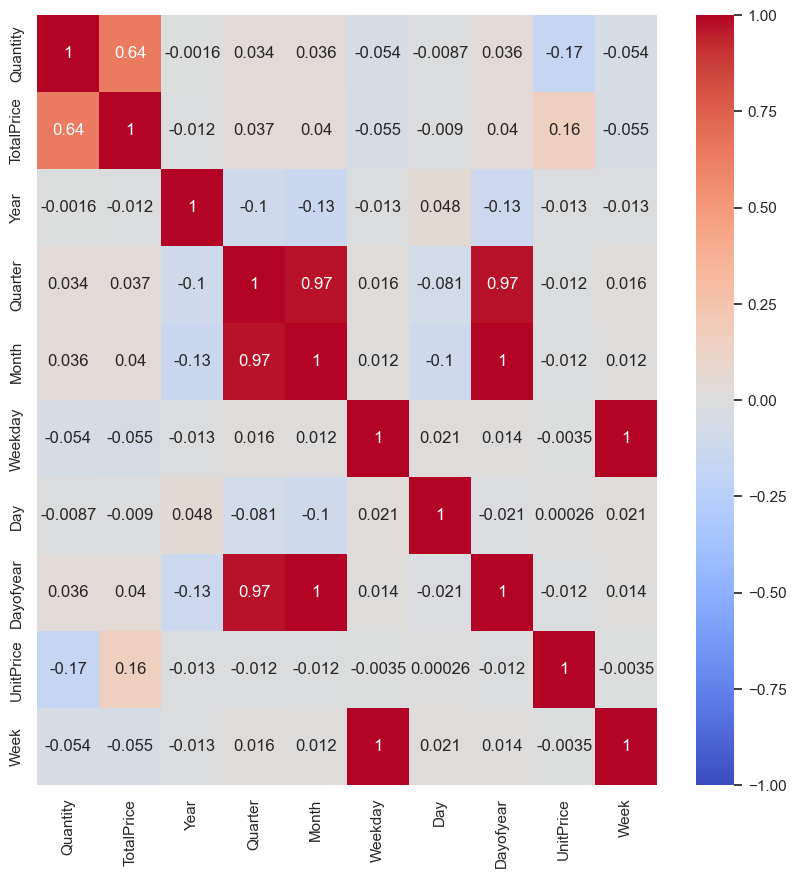

In [19]:
# Get correlations of each features in dataset
num_df=orders.select_dtypes(include=[np.number])
corrmat = num_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
# Plot heat map
g=sns.heatmap(orders[top_corr_features].corr(),annot=True,cmap="coolwarm",vmin=-1,vmax=1,center=0)

Above heatmap shows strong correlation between Quarter, Month, Dayofyear and Week. We will drop , Dayofyear, quarter and month, and just keep weekday, as weekday is most strongly correlated with weekday. Year has strong correlation with Day, and as it is not strongly correlated with Quantity, we will drop it.

In [20]:
orders.drop(['Month', 'Quarter','Dayofyear','Year'], axis=1,inplace=True)

In [21]:
orders.head()

,InvoiceDate,StockCode,Quantity,TotalPrice,Weekday,Day,UnitPrice,Week
0,2009-12-01,10002,12,10.20,1,1,0.85,1
1,2009-12-01,10120,60,12.60,1,1,0.21,1
2,2009-12-01,10125,4,3.40,1,1,0.85,1
3,2009-12-01,10133,6,5.10,1,1,0.85,1
4,2009-12-01,10135,17,21.25,1,1,1.25,1


In [22]:
orders.to_csv('data_inference.csv')